<h1>Linear Regression with Gradient Descent Using a Functional Programming Paradigm</h1>

<p>The first question that you are likely to ask seeing the title of this article is "wow that is long"! So let's break it down just in case any of this is new to you. Linear regression is simply fitting a line to a bunch of data to try to predict an outcome of one or more variables. Gradient descent means we are changing the margin in which we guess based off how bad, <i>or good</i>, our last guess was.</p>
<p>Now what is "a Functional Programming Paradigm" well you might guess that it just means we use functions in our program and sometimes that is what that term means. Here, however, it actually means that our functions are limited to the mathematical definition of a function. Something like <i>y = x<sup>2</sup></i>. We are limiting ourselves in that we cannot created and manipulate variables within a function and our output is directly tied to our input.</p> 
<p>This contrasts with procedural and object oriented programming where we can do things that you can't easily represent in standard math. In those paradigms what we are often doing is manipulating something called "state". In functional programming we don't have state; we only have math, at least in theory.</p>
<p>State essentially means that the output of a procedure in our program depends on a value stored elsewhere. In other words we cannot guarantee an output given an input. In our program here we are not going to be able to fully distance ourselves from state because we need to have an element of randomness which itself will depend on a bit of external state called a random seed. We will however mitigate this by always setting our random seed to 32 so that our program will have the same result each time it is run.  </p>
<p>Below I have an example of what is called a lambda-function. It is how we use functional programming in Python.</p>

In [1]:
square = lambda x: x ** 2

<p>This relates directly to the mathmaticall expression <i>f(x) = x<sup>2</sup></i> To break down the logic of this we can say "given an input <i>x</i> the output will be equal to <i>x</i> raised to the power of two".</p>
<p>The first thing we need to do is import some libraries. Of these only numpy will be used in the actually processing of our model. The others will make showing the result easier later on.</p>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

<p>Then we need to create the basic functions we will be working with.</p>

In [3]:
#Dot product numpy also has a built in dot function but I made my own instead of using it
dot = lambda x, y : sum([a*b for a, b in zip(x,y)])

#Create a nn style neuron based on input size for this program we will use only one
create_neuron = lambda x:([np.random.rand() * 5 - 2.5 for i in range(len(x))], np.random.rand())

#Relu activation function
relu = lambda x : max([0,x])

#Linear activation function
lin = lambda x : x

#Calculate the dot product plus the bias of a neuron then feed to activation function
process_neuron = lambda x, y, func = lin : func(dot(x[0], y) + x[1])

#returns updated nueron based on error
update_neuron = lambda neur, error: (
    [i + ((((i * np.random.rand()) * (error *2)) - error)) for i in neur[0] ],
    neur[1] + ((((neur[1] * np.random.rand()) * error) - error / 2))
    
)

#Create a toy regression dataset with linear features
create_x = lambda size, var_count :  [
    [(np.random.rand() * 2 -1)  for b in range( var_count)] for i in range( size)
]
create_y = lambda x, error : [sum([i + (i * np.random.rand() * error - error / 2) for i in a]) for a in x]

#Get mean squared error
mse = lambda y1, y2, : sum([(a-b)**2 for a,b in zip(y1,y2)]) / len(y2)

#this is a null model linear regression
null_model = lambda X, y: [np.mean(y) for _ in range(len(y))]

#Convert a 2d array first to a dictionary then to a dataframe
column = lambda data, ind: [a[ind]for a in data]
x_to_df = lambda x: pd.DataFrame({ f"X{i}":column(x, i) for i in range(len(x[0]))})

<p>These are more advanced functions that implement the model itself.</p>

In [4]:

#Run a linear regression
linear_regression = lambda x, neuron: [process_neuron(neuron, i) for i in x]

#check which of two neurons generates a better regression model
better_regression  = lambda x, y, neur1, neur2, fit=mse: neur1 if mse(linear_regression(x, neur1),y) < fit(linear_regression(x, neur2),y) else neur2

#take a neuron, mutate it based off mean squared error and return either the original or a new one based off comparitive performance
attempt_improvement = lambda x, y, neur: better_regression(x, y, neur, update_neuron(neur,mse(linear_regression(x, neur), y)))

#Train the model
train_regression = lambda x, y, neur, iters = 50 : (
    neur if iters <=0 
    else 
        train_regression(
                            x, 
                            y, 
                            attempt_improvement(x,y,neur),
                            iters -1
                        )
)

<p>You may have noticed that the last function calls itself. In standard paradigms we would use a loop but functional programming prefers recursion which is when a function call itself. This is because loops generally rely on storing data in variables and manipulating them each iteration.</p>
<p>I am grouping our weights and biases together in a structure I am calling a neuron. The way you get a prediction is take the dot product of the input variables and the weight and then add the bias to that. The trick here is that we are going to mutate the neuron many times while rejecting mutations that lessen the performace. Because functional programming forbids variable mutation we actually accomplish this through creating slightly mutated copies of the original. Now we are going to simulate some data and train the model.</p>

In [5]:
np.random.seed(32)
X = create_x(10000, 3)
y = create_y(X, .3)
X_train, y_train = X[0:8000], y[0:8000]
X_test, y_test = X[8000::], y[8000::]
neuron = create_neuron(X)

model = train_regression(X_train, y_train, neuron, iters=1000)


<p>Let's look at how we did. We are judging performace on mean squared error. To get that you use the following equation <i>image courtesy of wikipedia)</i>:</p>
<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/b9df6a0778ac37b2630be0d08d8b86e586313c66'></img><p>The function I made to do it may be easier to follow and you can find it above. The advantage of MSE is that it always gives us a positive number which makes working with it predictable. It also punishes bigger mistakes more than small ones.</p>
<p>We will then take a look at how we did.</p>

In [6]:
improvement = abs(mse(linear_regression(X_train, model), y_train) /mse(linear_regression(X_train, neuron), y_train) - 1) *100

print("\nTrain Data Mean Squared Errors:")
print(f"\tNull Model: {mse(null_model(X_train, y_train),y_train)}")
print(f"\tUntrained Model: {mse(linear_regression(X_train, neuron), y_train)}")
print(f"\tTrained Model: {mse(linear_regression(X_train, model), y_train)}")
print(f"\tTraining improved model by: {'{:.2f}'.format(improvement)}%")

improvement = abs(mse(linear_regression(X_test, model), y_test) /mse(linear_regression(X_test, neuron), y_test) - 1) *100

print("\nTest Data Mean Squared Errors:")
print(f"\tNull Model: {mse(null_model(X_train, y_train), y_test)}")
print(f"\tUntrained Model: {mse(linear_regression(X_test, neuron), y_test)}")
print(f"\tTrained Model: {mse(linear_regression(X_test, model), y_test)}")
print(f"\tTraining improved model by: {'{:.2f}'.format(improvement)}%")


Train Data Mean Squared Errors:
	Null Model: 1.3162465170133197
	Untrained Model: 1.5962406377977734
	Trained Model: 0.13778553956282846
	Training improved model by: 91.37%

Test Data Mean Squared Errors:
	Null Model: 1.2838679210279635
	Untrained Model: 1.4992655497831915
	Trained Model: 0.14280269886901575
	Training improved model by: 90.48%


<p>We trained our model on a subset of our data and then tested it on another subset. This is the standard way of doing things. The null model is just guessing the mean of our train data each time. The untrained model has its weights and biases randomized. And the trained model is the one we have worked up to this point to get it also started out identical to the untrained model. </p>

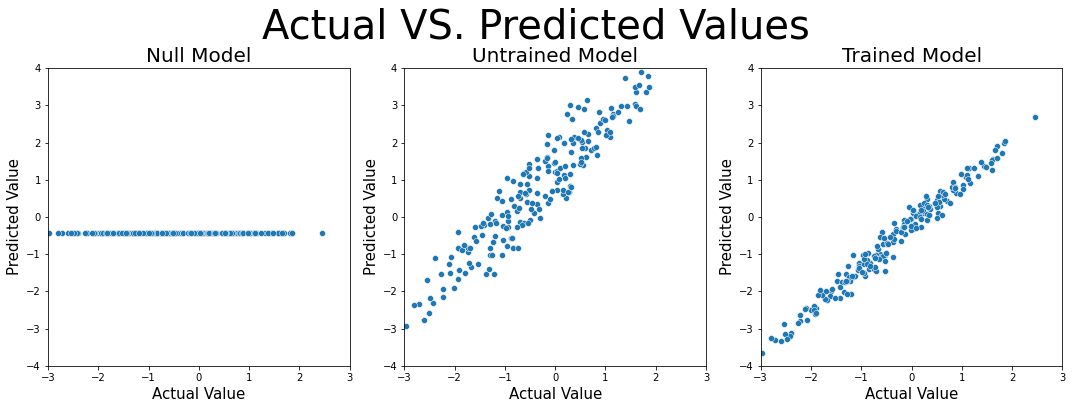

In [7]:
np.random.seed(32)
df = x_to_df(X_test)
df['y'] = y_test
df['pred'] = linear_regression(X_test, model)
df['untrained'] = linear_regression(X_test, neuron)
df['null'] = null_model(X_train, y_train)[:2000]
show = df.sample(200)




plt.figure(figsize=(15,15))
plt.subplot(3,3,1)
plt.suptitle("Actual VS. Predicted Values", fontsize=40)

sns.scatterplot(x='y', y='null',data=show  );
plt.title("Null Model",fontsize=20)
plt.ylabel('Predicted Value',fontsize=15)
plt.xlabel('Actual Value',fontsize=15);
plt.ylim(-4,4)
plt.xlim(-3,3)

plt.subplot(3,3,2)
sns.scatterplot(x='y', y='untrained',data=show  );
plt.title("Untrained Model",fontsize=20)
plt.ylabel('Predicted Value',fontsize=15)
plt.xlabel('Actual Value',fontsize=15);
plt.ylim(-4,4)
plt.xlim(-3,3)

plt.subplot(3,3,3)
sns.scatterplot(x='y', y='pred',data=show  );
plt.title("Trained Model",fontsize=20)
plt.ylabel('Predicted Value',fontsize=15)
plt.xlabel('Actual Value',fontsize=15);
plt.ylim(-4,4)
plt.xlim(-3,3)

plt.tight_layout();
plt.savefig('functional-linreg.png')

(-3.0, 3.0)

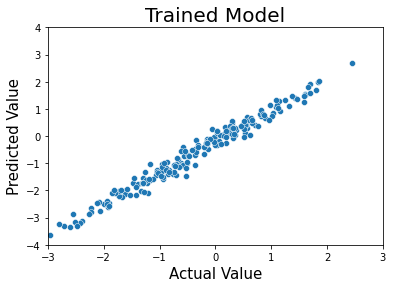

In [8]:
sns.scatterplot(x='y', y='pred',data=show  );
plt.title("Trained Model",fontsize=20)
plt.ylabel('Predicted Value',fontsize=15)
plt.xlabel('Actual Value',fontsize=15);
plt.ylim(-4,4)
plt.xlim(-3,3)

<p>Above I have plotted the predictions versus the actual values. This can give us a feel for how well our model behaved in a way that looking at raw numbers cannot.</p>
<p>The data is roughly linear and we want a model that reflects that. In the case of the null model it fails to capture the linear growth at all. The predictions of our untrained model are actually pretty good but that's really just a result of the implementation of the randomized initialization process. The trained model most closely follows a linear path. That means as the true value goes up so does the predicted value. It also means we did what we set out to do. We created a linear regression model using a functional programming paradigm.</p>

<p>There is of course one final question to answer; why did we do any of this? Plenty of libraries already exist for linear regression that have far more features and run faster. Well one good reason is that implementing something from scratch is a great way to make sure you know how it works. But then why use a style of programming that is fairly unusual for python? Well because there are in the world of computer science many people who argue that we should be using functional programming exclusively or at least predominantly. If you look on youtube or stackoverflow there are a million "hot takes" about it. The best way to know if they are onto something is to actually try to do what they say.</p>
<p>After completing this project I think I will make more use of functional programming since once you get something right it tends to not break. However, there are some drawbacks such as having to have functions call each other a lot more then you might otherwise need and the steps to mitigate that problem can cause your code to be far less readable. I think the solution is a combined rather than an all-or-nothing approach.</p>